(20000, 2)
[ 1.00000000e+00 -1.95133953e+00  4.73718729e+00  3.80772598e+00
 -9.24386084e+00  2.24409434e+01 -7.43016624e+00  1.80379111e+01
 -4.37899001e+01  1.06306952e+02  1.44987771e+01 -3.51980891e+01
  8.54489632e+01 -2.07440958e+02  5.03595941e+02 -2.82920370e+01
  6.86834228e+01 -1.66739940e+02  4.04787742e+02 -9.82686669e+02
  2.38562829e+03]
(20000, 2)


/var/folders/qk/cdd0ykb56dg3rz9bwzgqc28m0000gn/T/ipykernel_39952/1645547166.py:80: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xi,*_ = np.linalg.lstsq(theta,dx)
/var/folders/qk/cdd0ykb56dg3rz9bwzgqc28m0000gn/T/ipykernel_39952/1645547166.py:85: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  xi[big_inds],*_ = np.linalg.lstsq(theta[:,big_inds],dx)
/var/folders/qk/cdd0ykb56dg3rz9bwzgqc28m0000gn/T/ipykernel_39952/1645547166.py:80: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(

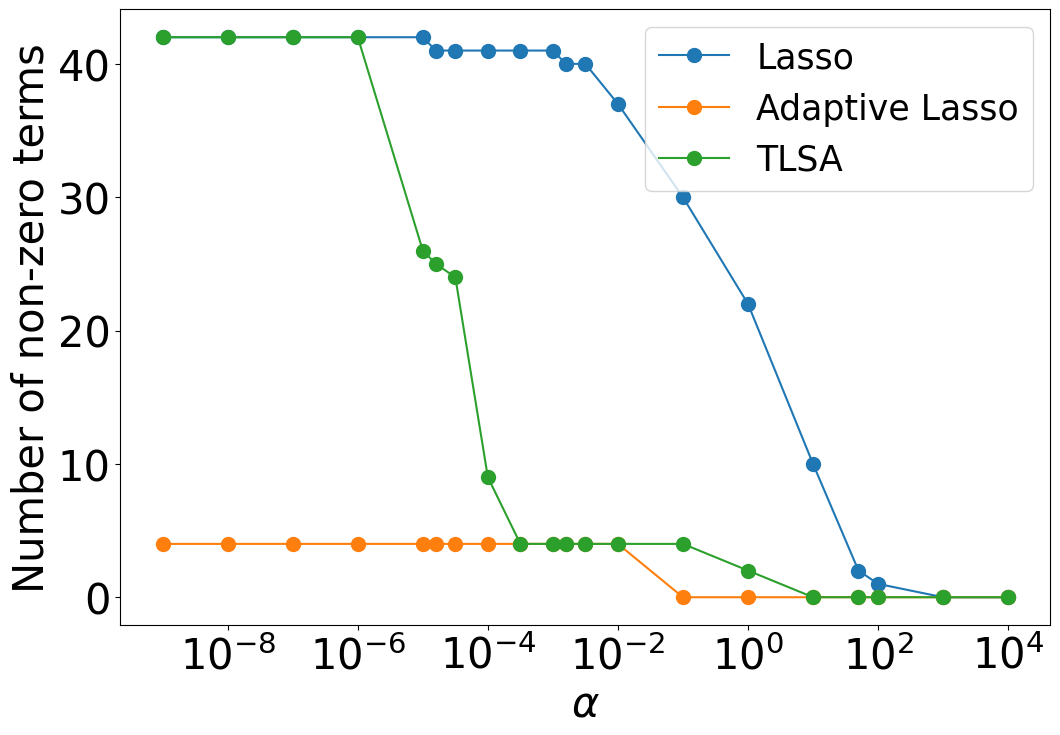

In [1]:
#van del pol方程式を使って、Lasso, TLSA, Adaptive Lasso, TLSAを比較する
import numpy as np
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import copy
import pysindy as ps

#van der pol方程式
def van_der_pol(x, t, kappa, order):
    dxdt = x[1]
    dydt = -x[0] + kappa * x[1] - kappa * x[0]**2 * x[1]

    return [dxdt, dydt]

def plot_data_and_derivative_2d(x, dt, deriv):
    feature_name = ["x", "y"]
    
    # データのプロット
    plt.figure(figsize=(15, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=18)

    # 導関数のプロット
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(15, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=18)
# 使い方
# plot_data_and_derivative_2d(training_data, dt, deriv_function)

def adaptive_lasso(XXX, yyy, alr):
    from sklearn.linear_model import Lasso
    # Params
    n_lasso_iterations = 100
    tol = 1e-12
    kaijo = 5
    abs1 = lambda w: (np.abs(w)**kaijo + 1e-30)

    n_samples, n_features = XXX.shape
    weights = np.ones(n_features)  # Prepare
    for k in range(n_lasso_iterations):
        prevw = np.copy(weights)
        XXX_w = XXX / weights[np.newaxis, :]  # STEP 1
        clf = Lasso(alpha=alr, fit_intercept=False, max_iter=n_lasso_iterations, tol=tol)  # STEP 2-1
        clf.fit(XXX_w, yyy)  # STEP 2-2
        coef_ = clf.coef_ / weights  # STEP 2-3
        weights = 1 / abs1(coef_)  # STEP 3
        if np.mean((weights - prevw)**2) < tol:
            break
    return coef_

def thresholded_least_squares(theta,dx,lam):
  ## sequential thresholded least-squared (STLS)
  xi,*_ = np.linalg.lstsq(theta,dx)
  for _ in range(10):
    small_inds = (np.abs(xi) < lam) # thredholded
    xi[small_inds] = 0.0
    big_inds = (small_inds == False)
    xi[big_inds],*_ = np.linalg.lstsq(theta[:,big_inds],dx)
  return xi

# Generate training data
t_train = np.linspace(0, 200, 20000)
kappa = 2
initial_condition = [-2, 5]
order = 4  # Specify the order of the polynomial terms
training_data = odeint(van_der_pol, initial_condition, t_train, args=(kappa, order))

# Compute finite differences for each coordinate
# 有限差分を計算している
dt = t_train[1] - t_train[0]
#data = training_data[:-1]  # Exclude the last point
#ddata = np.empty_like(data)
#for i in range(len(data) - 2):
#    ddata[i, 0] = (data[i + 2, 0] - data[i, 0]) / (2 * dt)
#    ddata[i, 1] = (data[i + 2, 1] - data[i, 1]) / (2 * dt)
data = training_data
#print(data.shape)
#print(ddata.shape)
#plot_data_and_derivative_2d(training_data, t_train, ps.FiniteDifference(order=2)._differentiate)
#時間微分を計算
ddata = ps.FiniteDifference(order=2)._differentiate(training_data, t_train)
print(ddata.shape)

# Build the right-hand side matrix based on the selected order
degree = 5

#候補関数ライブラリを作成
poly = PolynomialFeatures(degree=degree)
RHS = poly.fit_transform(data)
print(RHS[1, :])

#Create LHS matrix
LHS = copy.deepcopy(ddata)
print(LHS.shape)
LHS_X = LHS[:, 0]
LHS_Y = LHS[:, 1]

#正則化項のパラメータを変えながら、非ゼロの項の数をプロット
alpha_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 10**(-4.8), 10**(-4.5), 1e-4, 10**(-3.5), 1e-3, 10**(-2.8),10**(-2.5), 1e-2, 1e-1, 1, 10, 50, 100, 1000, 10000]
lasso_non_zero_terms_list = []
elastic_net_non_zero_terms_list = []
adaptive_lasso_non_zero_terms_list = []
tlsa_non_zero_terms_list = [] 

for alpha in alpha_values:
    # Lasso
    lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000)
    lasso.fit(LHS, RHS)
    non_zero_terms_lasso = np.count_nonzero(lasso.coef_)
    lasso_non_zero_terms_list.append(non_zero_terms_lasso)

    # ElasticNet
    #elastic_net = ElasticNet(alpha=alpha, l1_ratio=0.5, fit_intercept=False, max_iter=10000)
    #elastic_net.fit(LHS, RHS)
    #non_zero_terms_elastic_net = np.count_nonzero(elastic_net.coef_)
    #elastic_net_non_zero_terms_list.append(non_zero_terms_elastic_net)

    # Adaptive Lasso
    adaptive_lasso_coefficients_X = adaptive_lasso(RHS, LHS_X, alr=alpha)
    adaptive_lasso_coefficients_Y = adaptive_lasso(RHS, LHS_Y, alr=alpha)
    non_zero_terms_adaptive_lasso_X = np.count_nonzero(adaptive_lasso_coefficients_X)
    non_zero_terms_adaptive_lasso_Y = np.count_nonzero(adaptive_lasso_coefficients_Y)
    adaptive_lasso_non_zero_terms_list.append(non_zero_terms_adaptive_lasso_X + non_zero_terms_adaptive_lasso_Y)
    
	# Thresholded Least Squares Algorithm (TLSA)
    threshold = alpha  # Adjust threshold as needed
    tlsa_coefficients_X = thresholded_least_squares(RHS, LHS_X, threshold)
    tlsa_coefficients_Y = thresholded_least_squares(RHS, LHS_Y, threshold)
    non_zero_terms_tlsa_X = np.count_nonzero(tlsa_coefficients_X)
    non_zero_terms_tlsa_Y = np.count_nonzero(tlsa_coefficients_Y)
    tlsa_non_zero_terms_list.append(non_zero_terms_tlsa_X + non_zero_terms_tlsa_Y)

# Plot the number of non-zero terms for each alpha
plt.figure(figsize=(12, 8))
plt.plot(alpha_values, lasso_non_zero_terms_list, marker='o', markersize=10, label='Lasso')
#plt.plot(alpha_values, elastic_net_non_zero_terms_list, marker='o', label='ElasticNet')
plt.plot(alpha_values, adaptive_lasso_non_zero_terms_list, marker='o', markersize=10, label='Adaptive Lasso')
plt.plot(alpha_values, tlsa_non_zero_terms_list, marker='o', markersize=10, label='TLSA') 
plt.xscale('log')  # Use log scale for better visibility
plt.xlabel(r'$\alpha$',fontsize=30)
plt.ylabel('Number of non-zero terms',fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=25)
plt.show()